In [8]:
import os
import tqdm
import matplotlib.pyplot as plt
import torch

from models.select_network import define_G
from data.dataset_multiblur import Dataset

import utils.utils_image as util
import utils.utils_sisr as sisr

In [12]:
with open("localconfig/cocopath.txt", "r") as f:
    DATA_DIR = f.readline()

In [13]:
opt_net = {"netG" : {"net_type": "dmbsr"
                    , "n_iter": 8
                    , "h_nc": 64
                    , "in_nc": 4
                    , "out_nc": 3
                    , "ksize": 25
                    , "nc": [64, 128, 256, 512]
                    , "nb": 2
                    , "gc": 32
                    , "ng": 2
                    , "reduction" : 16
                    , "act_mode": "R" 
                    , "upsample_mode": "convtranspose" 
                    , "downsample_mode": "strideconv"},
           "is_train": False}

path_pretrained = r'model_zoo/DMBSR.pth'
netG = define_G(opt_net)
netG.load_state_dict(torch.load(path_pretrained))
netG = netG.to('cuda')

In [ ]:
opt_data = { "phase": "train"
          , "dataloader_batch_size": 1
          , "dataset_type": "multiblur"
          , "dataroot_H": os.path.join(DATA_DIR, 'images', 'val2017')
          , "H_size": 256
          , "scales": [2]
          , "sigma": [5, 10]
          , "sigma_test": 10
          , "n_channels": 3
          , "motion_blur": True
          , "coco_annotation_path": os.path.join(DATA_DIR, 'annotations', 'instances_val2017.json')}

data = Dataset(opt_data)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


  0%|          | 0/5 [00:00<?, ?it/s]

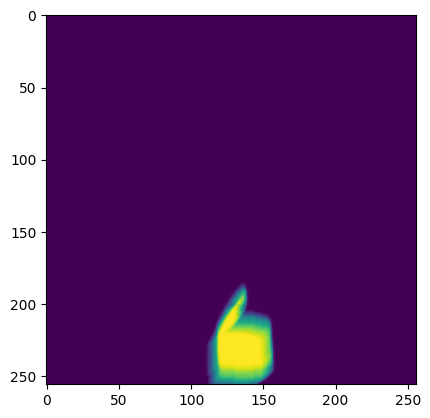

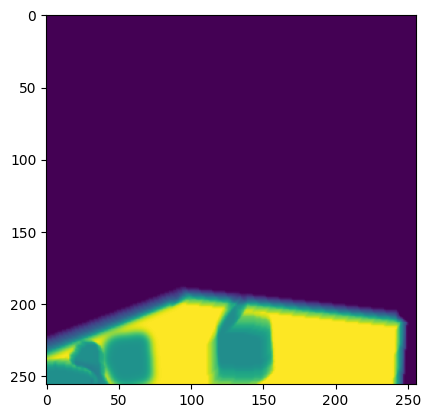

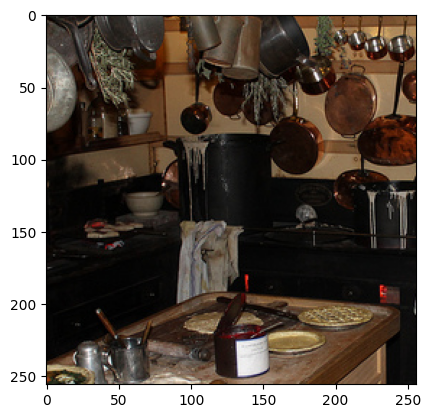

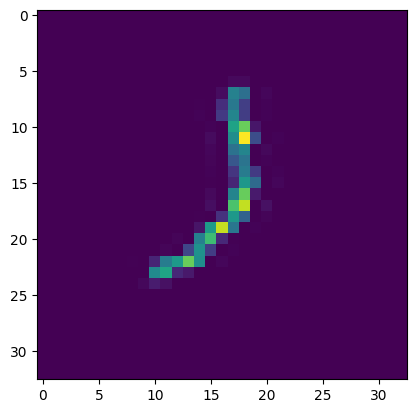

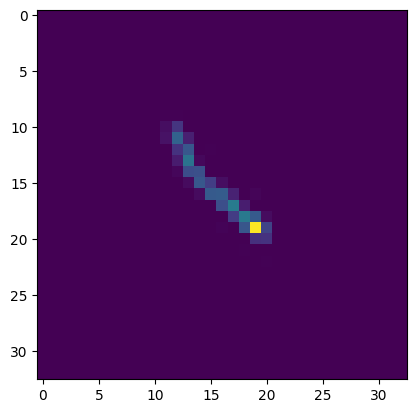

  0%|          | 0/5 [05:05<?, ?it/s]


KeyboardInterrupt: 

In [37]:
for i in tqdm.tqdm(range(5)):
    data.sf = 1
    data.count = -1
    sample = data[i]
    HR = util.tensor2uint(sample['H'])
    LR = util.tensor2uint(sample['L'])
    y = sample['L'][None].to('cuda')
    kmap = sample['kmap'][None].to('cuda')
    basis = sample['basis'][None].to('cuda')
    sf = sample['sf']
    sigma = sample['sigma'][None].to('cuda')
    
    res = netG(y, kmap, basis, sf, sigma)
    res = util.tensor2uint(res)
    
    
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(LR)
    plt.title('LR')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(res)
    plt.title('DMBSR')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(HR)
    plt.title('HR')
    plt.axis('off')
    plt.show()